# Cats VS Dogs Notebook
In this notebook we will try classifing pictures of dogs/cats from the dataset Dogs vs. Cats (https://www.kaggle.com/c/dogs-vs-cats).  
Using neural-networks is forbidden.

In [1]:
#libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preview

In [2]:
#example picture
exm=cv2.imread("Datasets/DvC/cat.0.jpg")#loading image
exm = cv2.cvtColor(exm, cv2.COLOR_BGR2RGB)#converting from BGR to RGB

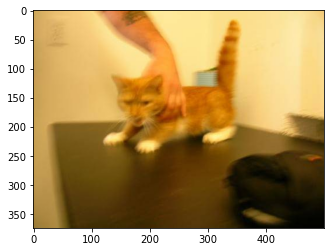

In [3]:
plt.imshow(exm)

In [4]:
exm.shape

(374, 500, 3)

We want to work with same-size images, we will reshape all images to the same scale.

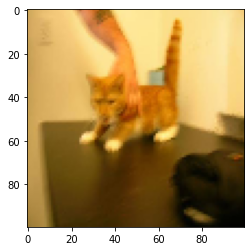

In [5]:
#first option- 100*100 colored
col_exm=cv2.resize(exm,(100,100))
plt.imshow(col_exm)

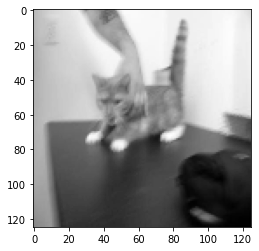

In [6]:
#second option- 125*125 grayscale
bnw_exm=cv2.cvtColor(exm, cv2.COLOR_RGB2GRAY)#grayscale image
bnw_exm=cv2.resize(bnw_exm,(125,125))
plt.imshow(bnw_exm,cmap='gray')

In [7]:
bnw_exm.shape

(125, 125)

The RGB dimensions were replaced with a single gray dimension

In [8]:
bnw_exm

array([[167, 173, 174, ..., 210, 206, 204],
       [167, 173, 174, ..., 211, 207, 205],
       [167, 173, 174, ..., 212, 208, 206],
       ...,
       [126, 128, 129, ...,   3,   3,   2],
       [125, 127, 129, ...,   3,   3,   3],
       [123, 124, 128, ...,   2,   2,   2]], dtype=uint8)

We can see that in both cases, even thogh the image is originally blurred we can still recognize the cat.  
Let's hope the computer will be able too.

We will work both on colored and grayscaled data and decide at the end what performs better and use this method for scoring.

# Option 1: Colored 100*100

## Data Importing

In [9]:
#Loading data
from os import listdir
X = list()
for file in listdir('Datasets/DvC/'):
    # load image
    im = cv2.imread("Datasets/DvC/"+file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)#to RGB
    #add to X
    X.append(cv2.resize(im,(100,100)))
    

The first 12500 images are cats and the last 12500 are dogs.  

In [10]:
#create labels
labels=np.zeros(12500)
y=np.concatenate((labels,np.ones(12500)))
y

array([0., 0., 0., ..., 1., 1., 1.])

In [11]:
y.shape

(25000,)

Text(0.5, 1.0, 'label is 0.0')

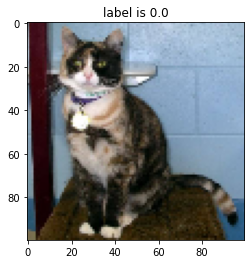

In [12]:
plt.imshow(X[12499])
plt.title('label is '+str(y[12499]))

Text(0.5, 1.0, 'label is 1.0')

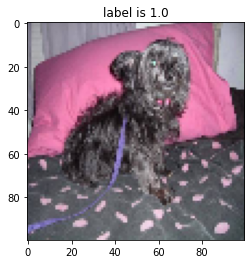

In [13]:
plt.imshow(X[12500])
plt.title('label is '+str(y[12500]))

## Data Preparations

In [14]:
#reducing to 2 dim array (for the algorithms)
X=np.asarray(X)
X.shape

(25000, 100, 100, 3)

In [15]:
X=X.reshape((25000,10000,3))
X=X.reshape((25000,30000))
X.shape

(25000, 30000)

In [16]:
#single picture as vector
X[15]

array([ 53,  49,   7, ...,  29, 156, 101], dtype=uint8)

In [17]:
#scaling
X.max()

255

In [18]:
X=X/255

In [19]:
#train-test split
from sklearn.model_selection import train_test_split
col_X_train, col_X_test, f_y_train, y_test = train_test_split(X, y, test_size=5000, random_state=42)
col_X_train.shape

(20000, 30000)

We won't touch the test sets until the very end.

We will extract validation sets from the training sets to help us choose the best estimator.

In [20]:
X_train, X_val, y_train, y_val = train_test_split(col_X_train, f_y_train, test_size=4000, random_state=42)
y_val.shape

(4000,)

The data is scaled and divided.  
The data is balanced, therefore the 'accuracy' metric will serve us well.

## Dimensionality reduction

Our data have too many dimensions (30000!), we have to reduce this number for our algorithms to run in a reasonable timeframe.  
We will use PCA (Principal Component Analysis) to reduce the dimension of our problem.  
We will create 2 reduced datasets (for each color scheme), one with 150 dimensions and the other with 20.  

In [21]:
from sklearn.decomposition import PCA
#20 dimensions
col_pca20=PCA(n_components=20,random_state=7)
X_train_20=col_pca20.fit_transform(X_train)

In [22]:
X_train_20.shape

(16000, 20)

In [23]:
#transform col_val by the same algorithm
X_val_20=col_pca20.transform(X_val)

In [24]:
#150 dimensions
col_pca150=PCA(n_components=150,random_state=7)
X_train_150=col_pca150.fit_transform(X_train)
X_val_150=col_pca150.transform(X_val)

In [25]:
X_train_150.shape

(16000, 150)

## Decision tree
### 20 dimensions

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score#to get close-to-life score
dtc=DecisionTreeClassifier(random_state=0,max_depth=15)
cvs=cross_val_score(dtc,X_train_20,y_train,cv=5,scoring='accuracy')
cvs

array([0.551875 , 0.564375 , 0.5565625, 0.55     , 0.558125 ])

In [27]:
cvs.mean()

0.5561875

The scores are really bad, just slightly above dummy model (coin flip/ persistent).  
Let's search for better depths that will still run in reasonable timeframe.

In [28]:
from sklearn.model_selection import GridSearchCV
grid=GridSearchCV(dtc,{'max_depth':[15,20,25,30,35]},cv=5,scoring='accuracy')
grid.fit(X_train_20,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=15, random_state=0),
             param_grid={'max_depth': [15, 20, 25, 30, 35]},
             scoring='accuracy')

In [29]:
cv_res=pd.DataFrame(grid.cv_results_)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.339238,0.004005,0.00353,0.006104,15,{'max_depth': 15},0.551875,0.564375,0.556562,0.550000,0.558125,0.556187,0.005056,1
1,0.371829,0.018239,0.00000,0.000000,20,{'max_depth': 20},0.540625,0.552188,0.549687,0.531563,0.557813,0.546375,0.009253,2
2,0.378089,0.011677,0.00000,0.000000,25,{'max_depth': 25},0.540937,0.544687,0.556875,0.532188,0.545000,0.543937,0.007952,3
3,0.381213,0.007641,0.00000,0.000000,30,{'max_depth': 30},0.550000,0.537813,0.548438,0.530312,0.545625,0.542437,0.007372,4
4,0.356229,0.020723,0.00000,0.000000,35,{'max_depth': 35},0.544687,0.536563,0.553750,0.525937,0.545625,0.541313,0.009419,5


The results are very interesting.

<AxesSubplot:xlabel='param_max_depth', ylabel='mean test score'>

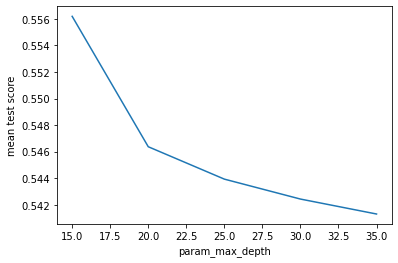

In [30]:
cv_res.plot(y='mean_test_score',x='param_max_depth',legend=False,ylabel='mean test score')

The accuracy decreases the deeper the tree.

In [31]:
#search with shalower trees
grid=GridSearchCV(dtc,{'max_depth':[5,7,10,12,15]},cv=5,scoring='accuracy')
grid.fit(X_train_20,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=15, random_state=0),
             param_grid={'max_depth': [5, 7, 10, 12, 15]}, scoring='accuracy')

<AxesSubplot:xlabel='param_max_depth', ylabel='mean test score'>

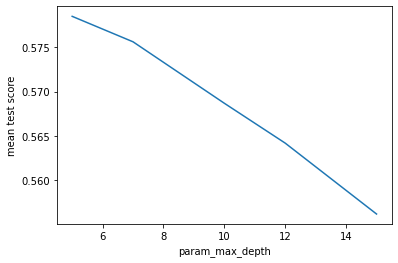

In [32]:
cv_res=pd.DataFrame(grid.cv_results_)
cv_res.plot(y='mean_test_score',x='param_max_depth',legend=False,ylabel='mean test score')

The results are still low, but the tree can serve as a weak learner for the following algorithms.

In [33]:
#full depth try
dtc.max_depth=None
cvs=cross_val_score(dtc,X_train_20,y_train,cv=5,scoring='accuracy')
cvs

array([0.5459375, 0.5365625, 0.55375  , 0.529375 , 0.545625 ])

Low performance even with powerful tree.

#### Evaluation

In [34]:
col_dtc20=grid.best_estimator_
col_dtc20.score(X_val_20,y_val)

0.57075

### 150 dimensions
Running time will be longer. hopefuly the results will be better.

In [35]:
dtc=DecisionTreeClassifier(random_state=0,max_depth=15)
cvs=cross_val_score(dtc,X_train_150,y_train,cv=5,scoring='accuracy')
cvs

array([0.543125 , 0.5525   , 0.555    , 0.5596875, 0.5471875])

In [36]:
cvs.mean()

0.5515000000000001

results are slightly worse than the 20-dim tree.

In [37]:
#search with shalower trees
grid=GridSearchCV(dtc,{'max_depth':[5,7,10,12,15]},cv=5,scoring='accuracy')
grid.fit(X_train_150,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=15, random_state=0),
             param_grid={'max_depth': [5, 7, 10, 12, 15]}, scoring='accuracy')

<AxesSubplot:xlabel='param_max_depth', ylabel='mean test score'>

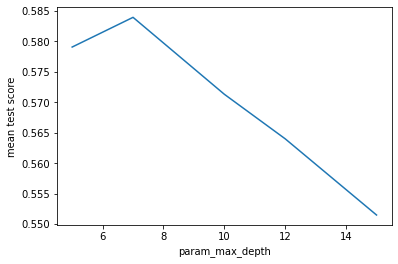

In [38]:
cv_res=pd.DataFrame(grid.cv_results_)
cv_res.plot(y='mean_test_score',x='param_max_depth',legend=False,ylabel='mean test score')

Best tree is max_depth=7.

In [39]:
#full depth try
dtc.max_depth=None
cvs=cross_val_score(dtc,X_train_150,y_train,cv=5,scoring='accuracy')
cvs.mean()

0.537125

Best parameter is max_depth=5.
#### Evaluation

In [40]:
col_dtc150=grid.best_estimator_
col_dtc150.score(X_val_150,y_val)

0.57925

The extra dimensions gave us slightly better score.

## Random Forest
### 20 dimensions

In [41]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=50,max_depth=5, random_state=10)
cvs=cross_val_score(rfc,X_train_20,y_train,cv=5,scoring='accuracy')
cvs

array([0.61625  , 0.609375 , 0.61125  , 0.6059375, 0.604375 ])

Resultes are better than single trees.

Let's find the best n_estimators value while experimenting with shalower trees (max_depth=2).

In [42]:
grid=GridSearchCV(rfc,{'n_estimators':[50,75,100,125],'max_depth':[2,5]},cv=5,scoring='accuracy')
grid.fit(X_train_20,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=5, n_estimators=50,
                                              random_state=10),
             param_grid={'max_depth': [2, 5],
                         'n_estimators': [50, 75, 100, 125]},
             scoring='accuracy')

Text(0.5, 1.0, 'score for estimators')

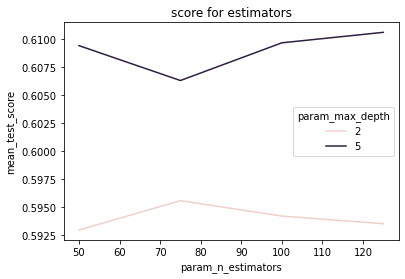

In [43]:
cv_res=pd.DataFrame(grid.cv_results_)
sns.lineplot(data=cv_res,y='mean_test_score',x='param_n_estimators',legend=True,hue='param_max_depth')
plt.title('score for estimators')

Highest score is with max_depth of 5 and 75 classifiers.

#### Evaluation

In [44]:
col_rfc20=grid.best_estimator_
col_rfc20.score(X_val_20,y_val)

0.6105

### 150 dimensions

In [45]:
rfc=RandomForestClassifier(n_estimators=50,max_depth=7,random_state=10)
cvs=cross_val_score(rfc,X_train_150,y_train,cv=5,scoring='accuracy')
cvs

array([0.6196875, 0.6190625, 0.621875 , 0.635    , 0.6165625])

Results seem better than 20 dim.  
Let's try different n_estimators.

In [46]:
grid=GridSearchCV(rfc,{'n_estimators':[50,75,100,125],'max_depth':[5,7]},cv=5,scoring='accuracy')
grid.fit(X_train_150,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=7, n_estimators=50,
                                              random_state=10),
             param_grid={'max_depth': [5, 7],
                         'n_estimators': [50, 75, 100, 125]},
             scoring='accuracy')

Text(0.5, 1.0, 'score for estimators')

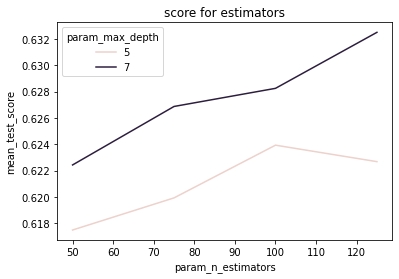

In [47]:
cv_res=pd.DataFrame(grid.cv_results_)
sns.lineplot(data=cv_res,y='mean_test_score',x='param_n_estimators',legend=True,hue='param_max_depth')
plt.title('score for estimators')

In [48]:
grid=GridSearchCV(rfc,{'n_estimators':[125,150,175]},cv=5,scoring='accuracy')
grid.fit(X_train_150,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=7, n_estimators=50,
                                              random_state=10),
             param_grid={'n_estimators': [125, 150, 175]}, scoring='accuracy')

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean test score'>

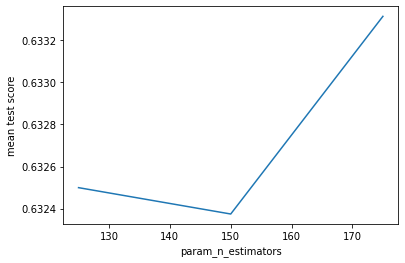

In [49]:
cv_res=pd.DataFrame(grid.cv_results_)
cv_res.plot(y='mean_test_score',x='param_n_estimators',legend=False,ylabel='mean test score')

In [50]:
grid=GridSearchCV(rfc,{'n_estimators':[175,200,225]},cv=5,scoring='accuracy')
grid.fit(X_train_150,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=7, n_estimators=50,
                                              random_state=10),
             param_grid={'n_estimators': [175, 200, 225]}, scoring='accuracy')

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean test score'>

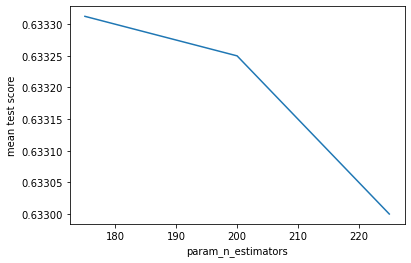

In [51]:
cv_res=pd.DataFrame(grid.cv_results_)
cv_res.plot(y='mean_test_score',x='param_n_estimators',legend=False,ylabel='mean test score')

We'll settle on 200 estimators.

#### Evaluation

In [52]:
col_rfc150=grid.best_estimator_
col_rfc150.score(X_val_150,y_val)

0.62125

Noticeable improvement over 20 dimensions.

## AdaBoost
### 20 dimensions

In [53]:
from sklearn.ensemble import AdaBoostClassifier
abc=AdaBoostClassifier(n_estimators=50,random_state=10)
cvs=cross_val_score(abc,X_train_20,y_train,cv=5,scoring='accuracy')
cvs

array([0.6015625, 0.5878125, 0.5921875, 0.59375  , 0.5925   ])

Not as good as random forest.

In [54]:
grid=GridSearchCV(abc,{'n_estimators':[50,75,100,125],'learning_rate':[0.8,1,1.2]},cv=5,scoring='accuracy')
grid.fit(X_train_20,y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=10),
             param_grid={'learning_rate': [0.8, 1, 1.2],
                         'n_estimators': [50, 75, 100, 125]},
             scoring='accuracy')

Text(0.5, 1.0, 'score for estimators')

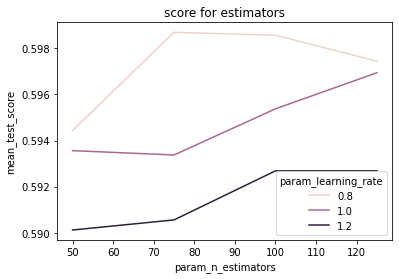

In [55]:
cv_res=pd.DataFrame(grid.cv_results_)
sns.lineplot(data=cv_res,y='mean_test_score',x='param_n_estimators',legend=True,hue='param_learning_rate')
plt.title('score for estimators')

The best score is for 0.8 learning rate and 75 estimators.  
We'll use that for evaluation.
#### Evaluation

In [56]:
col_abc20=grid.best_estimator_
col_abc20.score(X_val_20,y_val)

0.61225

### 150 dimensions

In [57]:
from sklearn.ensemble import AdaBoostClassifier
abc=AdaBoostClassifier(n_estimators=50,random_state=10)
cvs=cross_val_score(abc,X_train_150,y_train,cv=5,scoring='accuracy')
cvs

array([0.604375 , 0.6146875, 0.60625  , 0.6153125, 0.618125 ])

Slight improvement over 20 dim.

In [58]:
grid=GridSearchCV(abc,{'n_estimators':[50,75,100,125],'learning_rate':[0.8,1,1.2]},cv=5,scoring='accuracy')
grid.fit(X_train_150,y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=10),
             param_grid={'learning_rate': [0.8, 1, 1.2],
                         'n_estimators': [50, 75, 100, 125]},
             scoring='accuracy')

Text(0.5, 1.0, 'score for estimators')

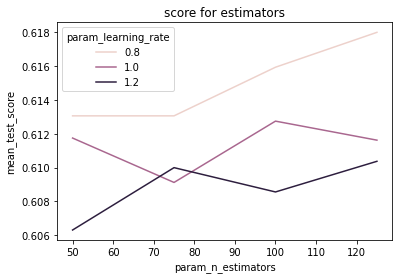

In [59]:
cv_res=pd.DataFrame(grid.cv_results_)
sns.lineplot(data=cv_res,y='mean_test_score',x='param_n_estimators',legend=True,hue='param_learning_rate')
plt.title('score for estimators')

Running time is very long, so we will not try higher estimators count.  
The best parameters are 125 estimators with learning rate of 0.8.

#### Evaluation

In [60]:
col_abc150=grid.best_estimator_
col_abc150.score(X_val_150,y_val)

0.6125

Improvement over 20 dim is minimal, even though we have more estimators and more data.

## Stacking
We will combine all three classifiers above to a single classifier. The classifier will recieve the predictions of each claassifier and will train on them (instead on the data).  
The final estimator is Logistic Regression.
### 20 dimensions

In [61]:
from sklearn.ensemble import StackingClassifier
col_sc20=StackingClassifier([('dtc',col_dtc20),('rfc',col_rfc20),('abc',col_abc20)])
col_sc20.fit(X_train_20,y_train)

StackingClassifier(estimators=[('dtc',
                                DecisionTreeClassifier(max_depth=5,
                                                       random_state=0)),
                               ('rfc',
                                RandomForestClassifier(max_depth=5,
                                                       n_estimators=125,
                                                       random_state=10)),
                               ('abc',
                                AdaBoostClassifier(learning_rate=0.8,
                                                   n_estimators=75,
                                                   random_state=10))])

#### Evaluation

In [62]:
col_sc20.score(X_val_20,y_val)

0.61025

A bit shy from AdaBoost 20 dim.

### 150 dimensions

In [63]:
col_sc150=StackingClassifier([('dtc',col_dtc150),('rfc',col_rfc150),('abc',col_abc150)])
col_sc150.fit(X_train_150,y_train)

StackingClassifier(estimators=[('dtc',
                                DecisionTreeClassifier(max_depth=7,
                                                       random_state=0)),
                               ('rfc',
                                RandomForestClassifier(max_depth=7,
                                                       n_estimators=175,
                                                       random_state=10)),
                               ('abc',
                                AdaBoostClassifier(learning_rate=0.8,
                                                   n_estimators=125,
                                                   random_state=10))])

#### Evaluating

In [64]:
col_sc150.score(X_val_150,y_val)

0.623

This is the best score we got so far.

## Colored 100*100 Conclusion

#### Best classifier for 20 dimensions is AdaBoost with 75 estimators and 0.8 learning rate (col_abc20, score:0.6122).  

#### Best classifier for 150 dimensions is the voting classifier, built from the best tree, forest and adaboost for 150 dimensions (col_cv150, score:0.623)





# Option 2: Black and white 125*125
We redo all the steps from before, explanation will be minimal.

In [75]:
del X, X_train, X_val #reset variables, save only col_X_train/test for final score (if necessary)
X = list()
for file in listdir('Datasets/DvC/'):
    # load image
    im = cv2.imread("Datasets/DvC/"+file)
    #add to X as black and whita image
    bnw_im=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)#grayscale image
    X.append(cv2.resize(bnw_im,(125,125)))

In [76]:
#reducing to 2 dim array (for the algorithms)
X=np.asarray(X)
X.shape

(25000, 125, 125)

In [77]:
X=X.reshape((25000,125*125))
X.shape

(25000, 15625)

In [79]:
#train-test split (same split as before)
bnw_X_train, bnw_X_test, f_y_train, y_test = train_test_split(X, y, test_size=5000, random_state=42)
bnw_X_train.shape

(20000, 15625)

In [80]:
X_train, X_val, y_train, y_val = train_test_split(f_X_train, f_y_train, test_size=4000, random_state=42)
y_val.shape

(4000,)

Data is ready to work.

## Dimensionality reduction
See Option 1:Colored for explanation

In [83]:
#20 dimensions
bnw_pca20=PCA(n_components=20,random_state=7)
X_train_20=bnw_pca20.fit_transform(X_train)
X_val_20=bnw_pca20.transform(X_val)
X_train_20.shape

(16000, 20)

In [84]:
#150 dimensions
bnw_pca150=PCA(n_components=150,random_state=7)
X_train_150=bnw_pca150.fit_transform(X_train)
X_val_150=bnw_pca150.transform(X_val)
X_val_150.shape

(4000, 150)

## Decision tree
### 20 dimensions

In [86]:
dtc=DecisionTreeClassifier(max_depth=15,random_state=13)
cv=cross_val_score(dtc,X_train_20,y_train,cv=5)
cv

array([0.5559375, 0.56375  , 0.556875 , 0.5496875, 0.555625 ])

In [90]:
grid=GridSearchCV(dtc,{'max_depth':[5,7,10,12,15,17]},cv=5,scoring='accuracy')
grid.fit(X_train_20,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=15, random_state=13),
             param_grid={'max_depth': [5, 7, 10, 12, 15, 17]},
             scoring='accuracy')

<AxesSubplot:xlabel='param_max_depth', ylabel='mean test score'>

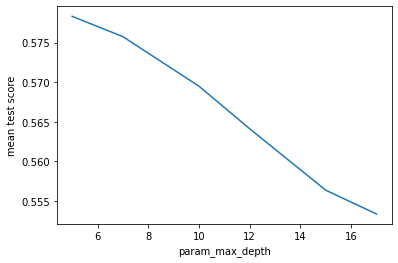

In [91]:
#show results
cv_res=pd.DataFrame(grid.cv_results_)
cv_res.plot(y='mean_test_score',x='param_max_depth',legend=False,ylabel='mean test score')

In [92]:
grid=GridSearchCV(dtc,{'max_depth':[5,7,10,12,15,17]},cv=5,scoring='accuracy')
grid.fit(X_train_20,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=15, random_state=13),
             param_grid={'max_depth': [5, 7, 10, 12, 15, 17]},
             scoring='accuracy')

<AxesSubplot:xlabel='param_max_depth', ylabel='mean test score'>

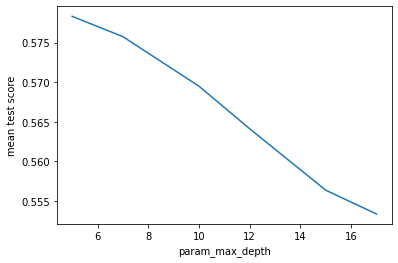

In [93]:
#show results
cv_res=pd.DataFrame(grid.cv_results_)
cv_res.plot(y='mean_test_score',x='param_max_depth',legend=False,ylabel='mean test score')

In [96]:
grid=GridSearchCV(dtc,{'max_depth':[2,3,4,5,6,7]},cv=5,scoring='accuracy')
grid.fit(X_train_20,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=15, random_state=13),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7]}, scoring='accuracy')

<AxesSubplot:xlabel='param_max_depth', ylabel='mean test score'>

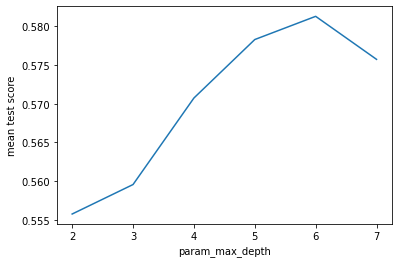

In [97]:
cv_res=pd.DataFrame(grid.cv_results_)
cv_res.plot(y='mean_test_score',x='param_max_depth',legend=False,ylabel='mean test score')

Best tree is max_depth=6.

#### Evaluation

In [98]:
bnw_dtc20=grid.best_estimator_
bnw_dtc20.score(X_val_20,y_val)

0.58

### 150 dimensions

In [99]:
grid=GridSearchCV(dtc,{'max_depth':[5,7,10,12,15,17]},cv=5,scoring='accuracy')
grid.fit(X_train_150,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=15, random_state=13),
             param_grid={'max_depth': [5, 7, 10, 12, 15, 17]},
             scoring='accuracy')

<AxesSubplot:xlabel='param_max_depth', ylabel='mean test score'>

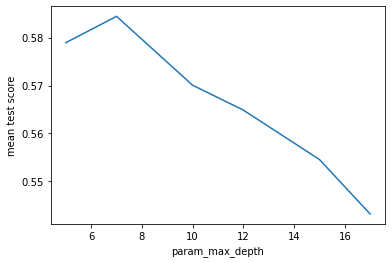

In [100]:
#show results
cv_res=pd.DataFrame(grid.cv_results_)
cv_res.plot(y='mean_test_score',x='param_max_depth',legend=False,ylabel='mean test score')

#### Evaluation

In [101]:
bnw_dtc150=grid.best_estimator_
bnw_dtc150.score(X_val_150,y_val)

0.57925

Lower than with 20 dim!

## Random Forest
### 20 dimensions

In [102]:
rfc=RandomForestClassifier(n_estimators=50,max_depth=5, random_state=10)
grid=GridSearchCV(rfc,{'n_estimators':[50,75,100,125],'max_depth':[5,7]},cv=5,scoring='accuracy')
grid.fit(X_train_20,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=5, n_estimators=50,
                                              random_state=10),
             param_grid={'max_depth': [5, 7],
                         'n_estimators': [50, 75, 100, 125]},
             scoring='accuracy')

Text(0.5, 1.0, 'score for estimators')

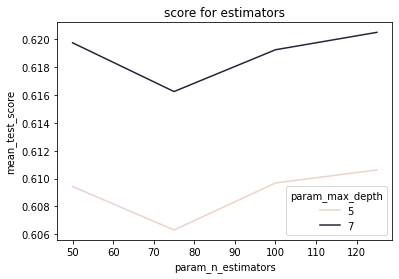

In [104]:
cv_res=pd.DataFrame(grid.cv_results_)
sns.lineplot(data=cv_res,y='mean_test_score',x='param_n_estimators',legend=True,hue='param_max_depth')
plt.title('score for estimators')

In [106]:
#continue searching with max_depth=7
rfc.max_depth=7
grid=GridSearchCV(rfc,{'n_estimators':[125,150,175,200]},cv=5,scoring='accuracy')
grid.fit(X_train_20,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=7, n_estimators=50,
                                              random_state=10),
             param_grid={'n_estimators': [125, 150, 175, 200]},
             scoring='accuracy')

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean test score'>

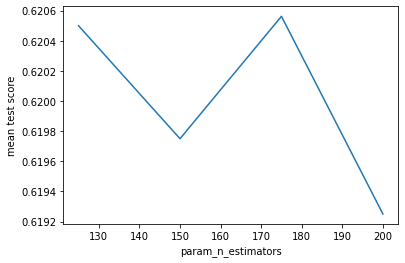

In [108]:
cv_res=pd.DataFrame(grid.cv_results_)
cv_res.plot(y='mean_test_score',x='param_n_estimators',legend=False,ylabel='mean test score')

#### Evaluation

In [109]:
bnw_rfc20=grid.best_estimator_
bnw_rfc20.score(X_val_20,y_val)

0.619